In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Imported libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc

"""
Data Validation & Preprocessing

This section of the script performs data validation and preprocessing on the recipe site traffic dataset.

Steps:
1. Load the dataset from a CSV file into a DataFrame.
2. Set display options to show all columns and rows for data inspection.
3. Inspect the data by printing information, summary statistics, and count of missing values.
4. Verify the uniqueness of the 'recipe' column and drop it as it does not offer predictive value.
5. One-hot encode the 'category' column and remove the 'category_' prefix from column names.
6. Clean and convert the 'servings' column to integer, and capitalize the column name for plotting.
7. Convert the 'high_traffic' column to binary format and boolean type for memory efficiency.
8. Calculate and print column variances.
9. Define columns with high variance and impute missing values using KNNImputer.
10. Log transform high variance columns to reduce the impact of variance.
11. Capitalize all column names in the DataFrame.
12. Inspect the final processed data.

Attributes:
- df: pandas DataFrame containing the dataset.
- identifier: Number of unique entries in the 'recipe' column.
- variances: Variance of each column in the DataFrame.
- highvar_cols: List of columns with high variance.
- imputer: KNNImputer instance used for imputing missing values.

Functions:
- log_transform(df, columns): Applies log transformation to specified columns in the DataFrame.

Usage:
Run the script to load, clean, and transform the recipe site traffic dataset, preparing it for further analysis or modeling.

"""

# Load the dataset from a CSV file into a DataFrame
df = pd.read_csv('recipe_site_traffic_2212.csv')

# Set display options to show all columns and rows for data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Inspect the data: print information, summary statistics, and count of missing values
print(df.info())
print()
print(df.describe())
print()
print(df.isna().sum())

# Verify that the 'recipe' column has 947 unique entries
identifier = df['recipe'].nunique()
print(f"\nThere's 947 rows in the dataset. The number of unique identifiers is {identifier}.")
# Drop the 'recipe' column as it is a unique identifier does not offer any predictive value
df = df.drop('recipe', axis=1)

# One-hot encode the 'category' column and remove the 'category_' prefix from column names
df = pd.get_dummies(df, columns=['category'])
df.columns = [col.replace('category_', '') for col in df.columns]

# Clean and convert the 'servings' column to integer, and capitalize the column name for plotting
df['servings'] = df['servings'].str.replace(' as a snack', '').astype('int8')

# Convert 'high_traffic' column to binary format and boolean type for memory efficiency
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)
df['high_traffic'] = df['high_traffic'].astype('bool')

# Calculate and print column variances
variances = df.var()
print("\nVariances:")
print(variances)

# Define the columns with high variance
highvar_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# Imputate missing values in highvar_cols
imputer = KNNImputer(n_neighbors=3)
df[highvar_cols] = imputer.fit_transform(df[highvar_cols])

# Log transform highvar_cols to reduce the impact of variance
def log_transform(df, columns):
    for column in columns:
        df[column] = np.log1p(df[column])
    return df

df = log_transform(df, highvar_cols)

# Capitalize all column names in the DataFrame
df.rename(columns={col: col.capitalize() for col in df.columns}, inplace=True)

# Inspect the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None

           recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375000    1.69

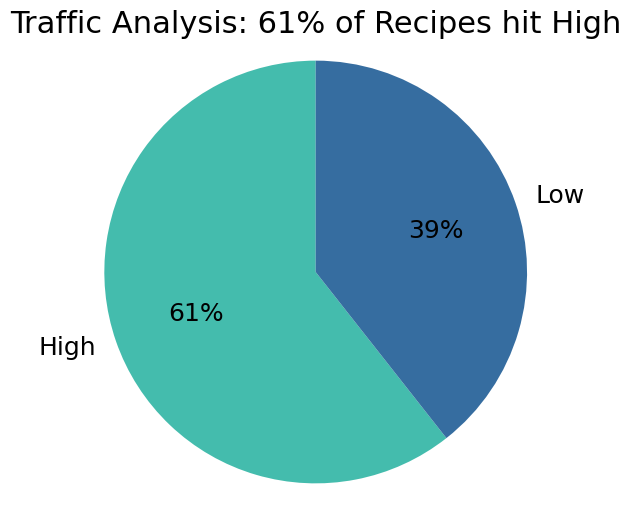

<Figure size 640x480 with 0 Axes>

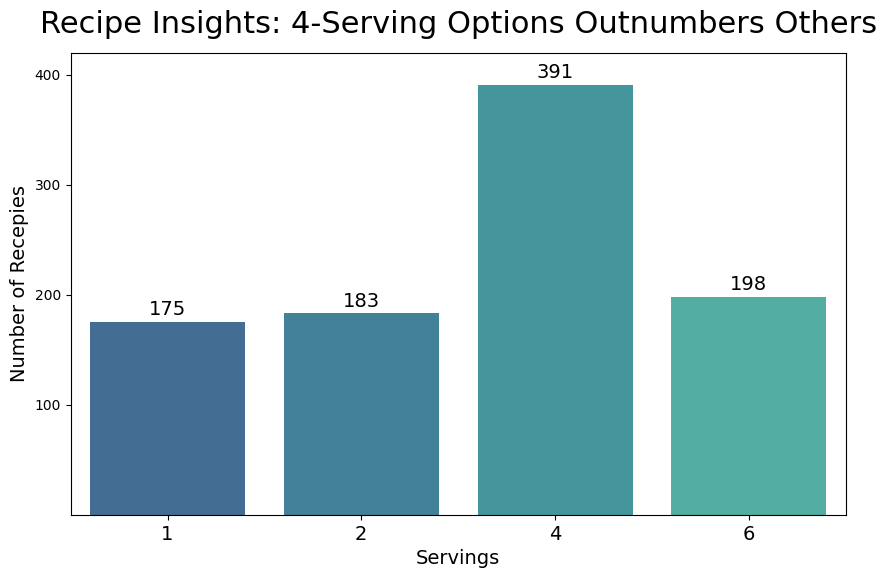

<Figure size 640x480 with 0 Axes>

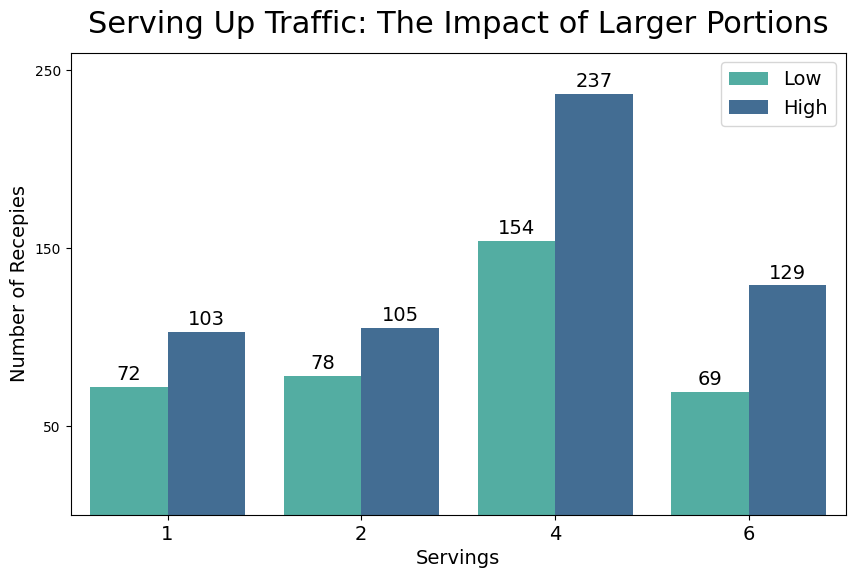

<Figure size 640x480 with 0 Axes>

In [3]:
"""
Exploratory Data Analysis (EDA)

This section of the script involves visualizing the data to gain insights into the distribution 
and relationships of various features.

Steps:
1. Extract color palettes for visualizations.
2. Plot a pie chart for the distribution of high traffic.
3. Plot a bar chart for the count of servings.
4. Plot a count plot for servings vs high traffic.

Attributes:
    mako (list): Color palette for visualizations.
    mako4 (list): Subset of the mako palette for visualizations with 4 variables.
    mako2 (list): Subset of the mako palette for visualizations with 2 variables.

Visualizations:
    - Pie chart for the distribution of high traffic.
    - Bar chart for the count of recipes for each number of servings.
    - Count plot for servings vs high traffic.

Usage:
Run this section to generate visualizations that provide insights into the distribution of high traffic 
and the count of servings in the recipe site traffic dataset.
"""

# Extract color palettes for visualisations
mako = sns.color_palette("mako", 10)
mako4 = mako[4:8]
mako2 = [mako[7], mako[4]]

# Plot a pie chart for the distribution of high traffic
high_traffic = df['High_traffic'].map({True: 'High', False: 'Low'}).value_counts()
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(high_traffic, labels=high_traffic.index, autopct='%1.0f%%', startangle=90, colors=mako2)
# Increase the font size of labels and percentage values
for text in texts:
    text.set_fontsize(18)
for autotext in autotexts:
    autotext.set_fontsize(18)
plt.title('Traffic Analysis: 61% of Recipes hit High', fontsize=22)
plt.axis('equal')
plt.show()
plt.clf()

# Plot a bar chart for the count of servings
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Servings', data=df, hue='Servings', palette=mako4, legend=False)
plt.title('Recipe Insights: 4-Serving Options Outnumbers Others', y=1.025, fontsize=22)
plt.xticks(fontsize=14)
plt.xlabel('Servings', fontsize=14)
ax.set_yticks([100, 200, 300, 400])
plt.ylim(0, 420)
plt.ylabel('Number of Recepies', fontsize=14)
# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()
plt.clf() 

# Plot a count plot for servings vs high traffic
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Servings', hue='High_traffic', data=df, palette=mako2)
# Add counts on top of each bar
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.title('Serving Up Traffic: The Impact of Larger Portions', y=1.025, fontsize=22)
plt.xticks(fontsize=14)
plt.xlabel('Servings', fontsize=14)
ax.set_yticks([50, 150, 250])
plt.ylim(0, 260)
plt.ylabel('Number of Recepies', fontsize=14)
plt.legend(title='', labels=['Low', 'High'], fontsize=14, title_fontsize=14)
plt.show()
plt.clf()

In [7]:
"""
Model Development

This section performs model development for predicting high traffic on a recipe site.

Problem Type:
- This is a binary classification problem where the target variable is 'high_traffic', indicating whether the traffic is high (1) or low (0).

Model Selection:
- Logistic Regression: Chosen for its simplicity and interpretability. It provides a good baseline for comparison.
- Random Forest: Selected for its ability to handle complex interactions and provide feature importance. It is a robust model that often performs well on a variety of datasets.

Steps:
1. Select models: 
    - Logistic Regression with a specified random state for reproducibility.
    - Support Vector Machine (SVM) with an RBF kernel and probability estimates
2. Split the data into features (X) and target variable (y).
3. Split the data into training and testing sets.
4. Fit the models on the training data.

Attributes:
    models (dict): A dictionary containing the selected models.
    X (DataFrame): Features for the model.
    y (Series): Target variable indicating high traffic.
    X_train (DataFrame): Training set features.
    X_test (DataFrame): Testing set features.
    y_train (Series): Training set target variable.
    y_test (Series): Testing set target variable.

Usage:
Run this section to select, split, and train the Logistic Regression and Support Vector Machine models on the recipe site traffic dataset.

"""

# Select models
models = {
    "Logistic Regression": LogisticRegression(random_state=12), 
    "Support Vector Machine": SVC(kernel='rbf', random_state=12, probability=True)
}

# Split the data into features (X) and target variable (y)
X = df.drop('High_traffic', axis=1)
y = df['High_traffic']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Fit the models on the training data
models["Logistic Regression"].fit(X_train, y_train)
print("\nLogistic Regression trained successfully.")
models["Support Vector Machine"].fit(X_train, y_train)
print("\nSupport Vector Machine trained successfully.")


Logistic Regression trained successfully.

Support Vector Machine trained successfully.



Logistic Regression Metrics:
Accuracy: 0.800
Precision: 0.846
Recall: 0.832
F1 Score: 0.839
ROC AUC Score: 0.835

Support Vector Machine Metrics:
Accuracy: 0.816
Precision: 0.804
Recall: 0.933
F1 Score: 0.864
ROC AUC Score: 0.823


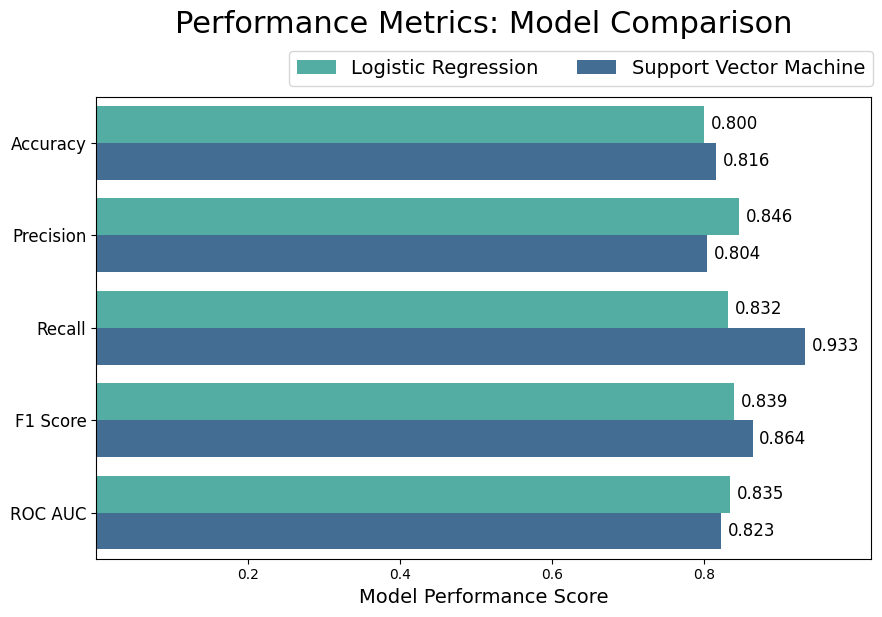

<Figure size 640x480 with 0 Axes>

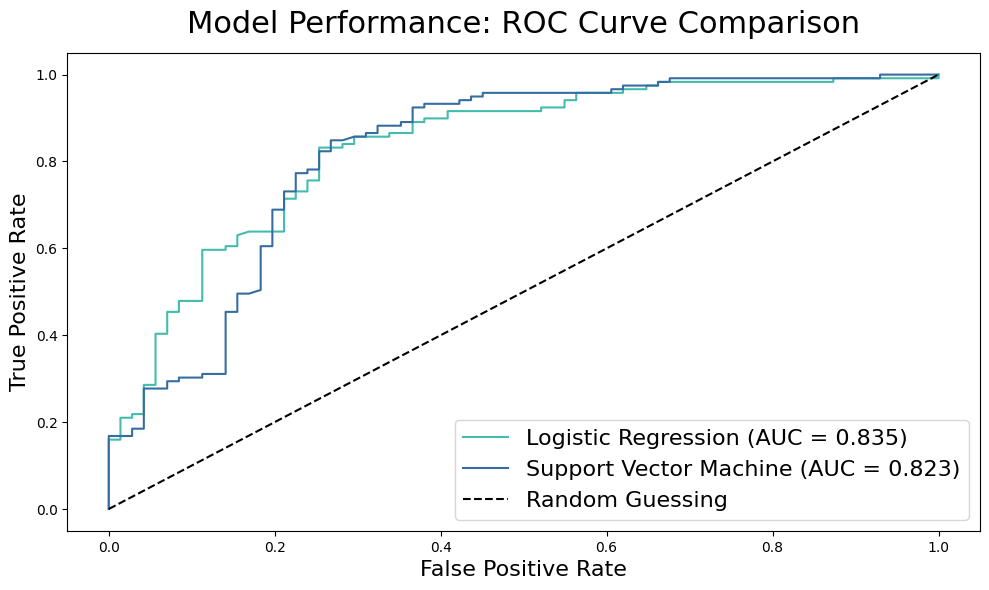

<Figure size 640x480 with 0 Axes>

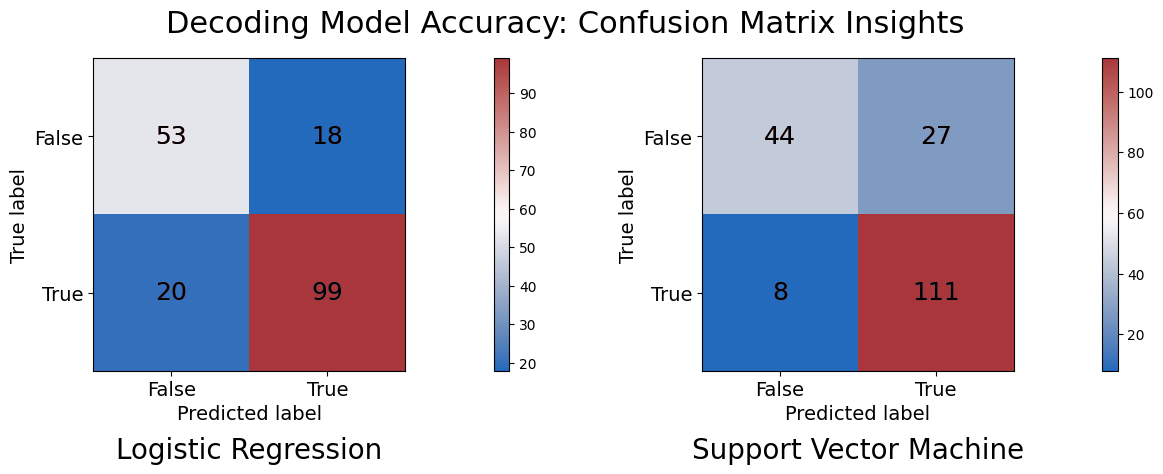

<Figure size 640x480 with 0 Axes>

In [11]:
"""
Model Evaluation

This section of the script evaluates the performance of machine learning models 
on the recipe site traffic dataset and visualizes the results.

Functions:
    print_metrics(y_true, y_pred, y_proba): Prints evaluation metrics for a given model.
    evaluate_model(model):  Evaluates a model using cross-validation and returns mean scores 
                            and standard deviations for multiple metrics.

Steps:
1. Define a function to print evaluation metrics for a model.
2. Calculate and print metrics for each model using the models variable.
3. Store performance metrics for both models in a dictionary.
4. Create a DataFrame for metrics and melt it for plotting.
5. Create a horizontal bar plot for model performance metrics.
6. Plot ROC curves for models.
7. Generate and plot confusion matrices for each model.
8. Create combined subplots for ROC curves and confusion matrices.

Evaluation Metrics:
- Accuracy: The proportion of correctly classified instances.
- Precision: The proportion of true positive instances among the instances predicted as positive.
- Recall: The proportion of true positive instances among the actual positive instances.
- F1 Score: The harmonic mean of precision and recall.
- ROC AUC Score: The area under the ROC curve, representing the model's ability to distinguish between classes.

Attributes:
- models: Dictionary containing the trained models.
- metrics: Dictionary to store performance metrics for both models.
- metrics_df: DataFrame containing the performance metrics.
- metrics_melted: Melted DataFrame for plotting.
- models_and_probabilities: Dictionary to store models and their predicted probabilities.
- cm_models: Dictionary to store models and their predictions for confusion matrices.

Usage:
Run this section to evaluate the performance of the Logistic Regression and Support Vector Machine models on 
the recipe site traffic dataset and visualize the results using various plots.

"""

# Function to print evaluation metrics for a model
def print_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC Score": roc_auc_score(y_true, y_proba) if y_proba is not None else None
    }
    for metric, score in metrics.items():
        if score is not None:
            print(f"{metric}: {score:.3f}")

# Calculate and print metrics for each model using the models variable
for model_name, model in models.items():
    print(f"\n{model_name} Metrics:")
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print_metrics(y_test, predictions, probabilities)

# Dictionary to store performance metrics for both models
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
}

for model_name in models.keys():
    predictions = models[model_name].predict(X_test)
    probabilities = models[model_name].predict_proba(X_test)[:, 1] if hasattr(models[model_name], "predict_proba") else None
    metrics[model_name] = [
        accuracy_score(y_test, predictions),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
        f1_score(y_test, predictions),
        roc_auc_score(y_test, probabilities) if probabilities is not None else None
    ]

# Creating DataFrame for metrics and melting it for plotting
metrics_df = pd.DataFrame(metrics)
metrics_melted = metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Creating horizontal bar plot for model performance metrics
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Score", y="Metric", hue="Model", data=metrics_melted, palette=mako2)
# Adding the value for each bar
for p in barplot.patches:
    width = p.get_width()
    if width > 0:
        plt.text(width + 0.04,
                 p.get_y() + p.get_height() / 2,
                 '{:.3f}'.format(width),
                 ha='center', va='center', fontsize=12)
plt.title('Performance Metrics: Model Comparison', y=1.12, fontsize=22)
plt.xlabel('Model Performance Score', fontsize=14)
plt.ylabel('')
plt.legend(title='', loc='upper left', bbox_to_anchor=(0.236, 1.12), fontsize=14, ncol=2)
plt.xlim(0, 1.02)
plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.yticks(fontsize=12)
plt.show()
plt.clf()

# ROC Curves for Models - Dictionary to store models and their predicted probabilities
models_and_probabilities = {"Logistic Regression": models["Logistic Regression"].predict_proba(X_test)[:, 1], 
                            "Support Vector Machine": models["Support Vector Machine"].predict_proba(X_test)[:, 1]}

# Plot ROC curves
plt.figure(figsize=(10, 6))
for (model_name, y_proba), color in zip(models_and_probabilities.items(), mako2):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", color=color)

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Model Performance: ROC Curve Comparison", y=1.025, fontsize=22)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()
plt.clf()

# Confusion Matrices - Generate predictions and create a dictionary for storing models and their predictions
cm_models = {model_name: (models[model_name], models[model_name].predict(X_test)) for model_name in models.keys()}

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, len(cm_models), figsize=(12 * len(cm_models), 5))
fig.suptitle("Decoding Model Accuracy: Confusion Matrix Insights", fontsize=22, x=0.66)
# Plot each confusion matrix
for ax, (model_name, (model, y_pred)) in zip(axes if len(cm_models) > 1 else [axes], cm_models.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax if len(cm_models) > 1 else axes,
                                                   cmap='vlag', text_kw={'fontsize': 18})
    ax.set_title('')
    # Customize text annotations
    cm = disp.confusion_matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j if len(cm_models) > 1 else axes.get_xticks()[j], i if len(cm_models) > 1 else axes.get_yticks()[i],
                    format(cm[i][j], 'd'), ha='center', va='center', color='black', fontsize=18)
    # Increase the size of x and y labels and ticks
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.annotate(model_name, xy=(0.5, -0.28), xycoords='axes fraction', ha='center', fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(wspace=-0.95)
plt.tight_layout()
plt.show()
plt.clf()

In [13]:
"""

Feature Scaling & Hyperparameter Tuning

This section scales the features, defines models, sets parameter grids, and performs RandomizedSearchCV
to find the best parameters for Logistic Regression and Support Vector Machine models.

Steps:
1. Scale the features using MaxAbsScaler.
3. Set parameter grids for RandomizedSearchCV.
4. Perform RandomizedSearchCV to find the best parameters for Logistic Regression.
5. Perform RandomizedSearchCV to find the best parameters for Support Vector Machine.
6. Update the models dictionary with the best estimators.

Variables:
    scaler (MaxAbsScaler): Scaler object to standardize the features.
    X_train (ndarray): Scaled training features.
    X_test (ndarray): Scaled testing features.
    param_grid_lr (dict): Parameter grid for RandomizedSearchCV for Logistic Regression.
    param_grid_svc (dict): Parameter grid for RandomizedSearchCV for Support Vector Machine.
    random_search_lr (RandomizedSearchCV): RandomizedSearchCV object for Logistic Regression.
    random_search_svc (RandomizedSearchCV): RandomizedSearchCV object for Support Vector Machine.

"""

# Scale the features
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define parameter grids for RandomizedSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Perform RandomizedSearchCV for Logistic Regression
random_search_lr = RandomizedSearchCV(models["Logistic Regression"], param_grid_lr, n_iter=20, cv=StratifiedKFold(n_splits=4), random_state=12)
random_search_lr.fit(X_train, y_train)
models["Logistic Regression"] = random_search_lr.best_estimator_

# Perform RandomizedSearchCV for Support Vector Machine
random_search_svc = RandomizedSearchCV(models["Support Vector Machine"], param_grid_svc, n_iter=20, cv=StratifiedKFold(n_splits=4), random_state=12)
random_search_svc.fit(X_train, y_train)
models["Support Vector Machine"] = random_search_svc.best_estimator_


Logistic Regression Cross-Validation Metrics:
Accuracy - Mean: 0.756, Std Dev: 0.032
Precision - Mean: 0.785, Std Dev: 0.028
Recall - Mean: 0.817, Std Dev: 0.040
F1 - Mean: 0.801, Std Dev: 0.027
ROC AUC - Mean: 0.820, Std Dev: 0.031

Support Vector Machine Cross-Validation Metrics:
Accuracy - Mean: 0.756, Std Dev: 0.032
Precision - Mean: 0.793, Std Dev: 0.033
Recall - Mean: 0.804, Std Dev: 0.023
F1 - Mean: 0.798, Std Dev: 0.025
ROC AUC - Mean: 0.755, Std Dev: 0.056


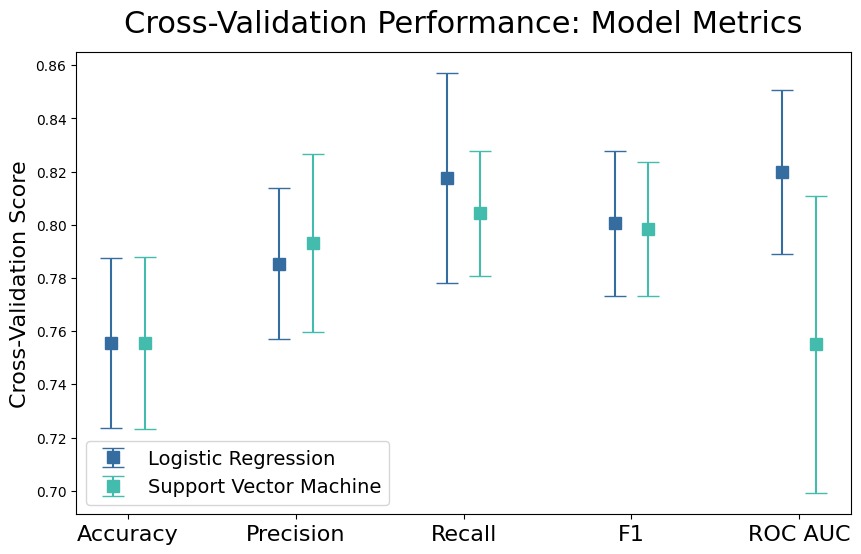

           Feature  Logistic Regression
0        Beverages             1.000000
1        Vegetable             0.837564
2           Potato             0.752933
3             Pork             0.540830
4          Chicken             0.457874
5        Breakfast             0.424944
6   Chicken breast             0.272772
7         Calories             0.135543
8             Meat             0.102507
9    One dish meal             0.077050
10         Dessert             0.069937
11         Protein             0.048400
12    Carbohydrate             0.047183
13           Sugar             0.040202
14        Servings             0.018745
15    Lunch/snacks             0.006372

           Feature  Support Vector Machine
0        Beverages                1.000000
1        Breakfast                0.744501
2   Chicken breast                0.231810
3          Chicken                0.027073
4         Calories                0.000000
5     Carbohydrate                0.000000
6            Sugar

<Figure size 640x480 with 0 Axes>

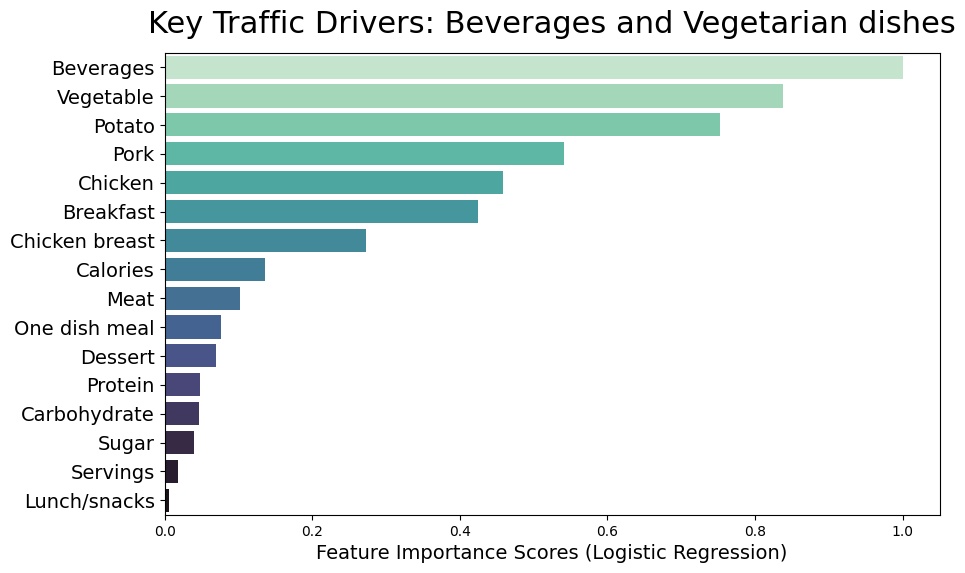

<Figure size 640x480 with 0 Axes>

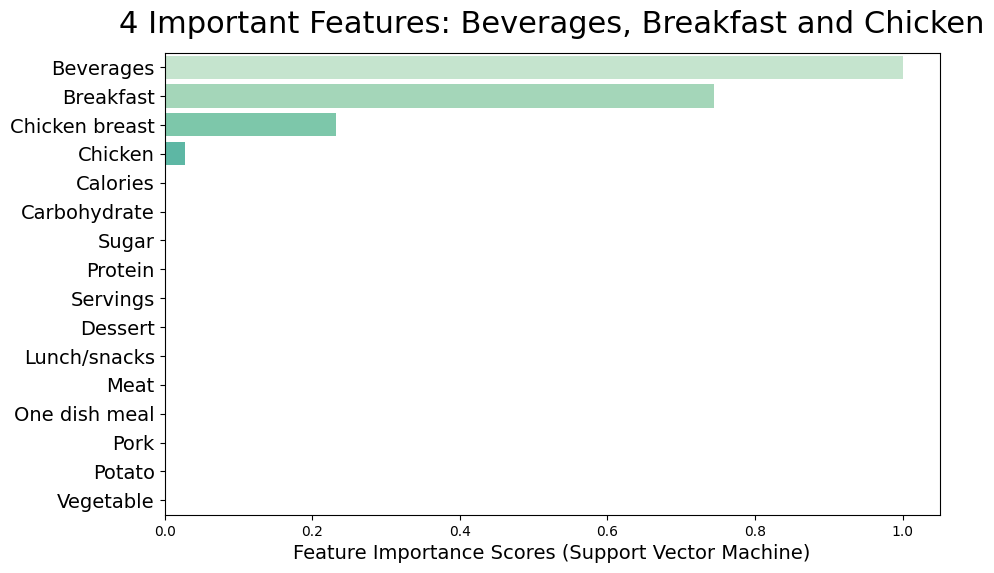

<Figure size 640x480 with 0 Axes>

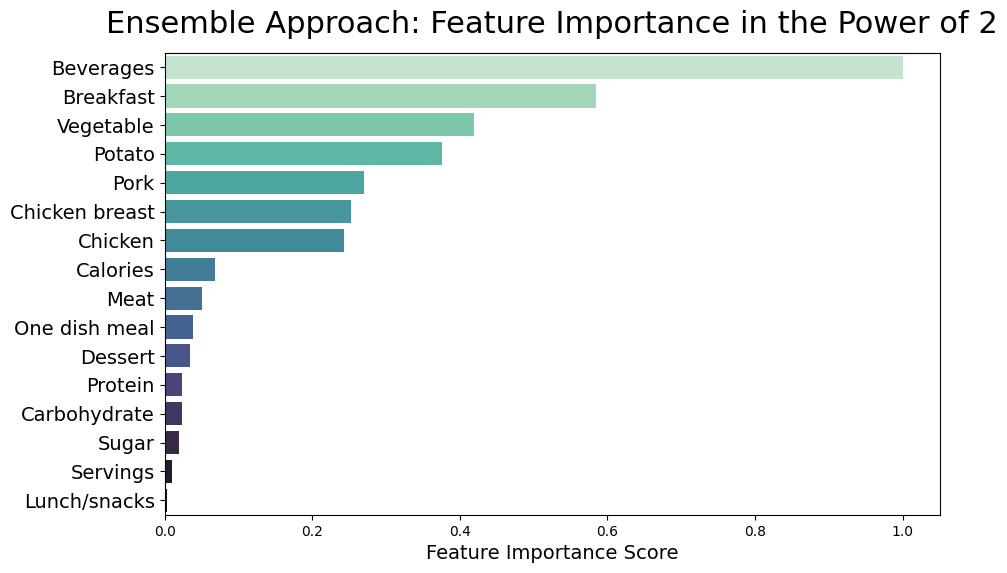

<Figure size 640x480 with 0 Axes>

In [17]:
"""

Cross Validation & Feature Importances

This section of the code evaluates machine learning models using cross-validation, 
calculates feature importances by applying an ensemble approach, and visualizes the results.

Steps:
1. Define the evaluate_model function to evaluate models and calculate feature importances.
2. Evaluate models using cross-validation and store metrics.
3. Print the mean scores and standard deviations for all metrics after cross-validation.
4. Plot cross-validation metrics for each model.
5. Normalize and average feature importances.
6. Sort and print feature importances for Logistic Regression, Support Vector Machine, and their average.
7. Plot feature importances for Logistic Regression, Support Vector Machine, and their average.

Functions:
    evaluate_model(model): Evaluates a given model using cross-validation and calculates feature importances.

Variables:
    cv_metrics (dict): Dictionary to store cross-validation metrics.
    feature_importances_dict (dict): Dictionary to store feature importances for each model.
    cv_metrics_df (DataFrame): DataFrame containing cross-validation metrics.
    importance_df (DataFrame): DataFrame containing feature importances for each model and their average.
    importance_df_lr_sorted (DataFrame): DataFrame containing sorted feature importances for Logistic Regression.
    importance_df_svm_sorted (DataFrame): DataFrame containing sorted feature importances for Support Vector Machine.
    importance_df_avg_sorted (DataFrame): DataFrame containing sorted average feature importances.

"""

# Function to evaluate models and calculate feature importances
def evaluate_model(model):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=StratifiedKFold(n_splits=4), scoring=scoring)
    mean_scores = {metric: cv_results[f'test_{metric}'].mean() for metric in scoring}
    std_scores = {metric: cv_results[f'test_{metric}'].std() for metric in scoring}
    feature_importances = abs(model.coef_[0]) if isinstance(model, LogisticRegression) else permutation_importance(model, X_test, y_test, n_repeats=20, random_state=12).importances_mean
    return mean_scores, std_scores, feature_importances

# Evaluate models and store metrics
cv_metrics = {"Metric": ["Accuracy", "Precision", "Recall", "F1", "ROC AUC"]}
feature_importances_dict = {}
for model_name, model in models.items():
    mean_scores, std_scores, feature_importances = evaluate_model(model)
    cv_metrics.update({f"{model_name} Mean": list(mean_scores.values()), f"{model_name} Std Dev": list(std_scores.values())})
    feature_importances_dict[model_name] = feature_importances

# Print the mean scores and standard deviations for all metrics after cross-validation
for model_name in models.keys():
    print(f"\n{model_name} Cross-Validation Metrics:")
    for metric in cv_metrics["Metric"]:
        mean_score = cv_metrics[f"{model_name} Mean"][cv_metrics['Metric'].index(metric)]
        std_dev = cv_metrics[f"{model_name} Std Dev"][cv_metrics['Metric'].index(metric)]
        print(f"{metric} - Mean: {mean_score:.3f}, Std Dev: {std_dev:.3f}")

# Plot cross-validation metrics
cv_metrics_df = pd.DataFrame(cv_metrics)
plt.figure(figsize=(10, 6))
offset = 0.2
colors = [mako[4], mako[7]] 
for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
    plt.errorbar([j + (i - 0.5) * offset for j in range(len(cv_metrics_df["Metric"]))], cv_metrics_df[f"{model_name} Mean"], 
                 yerr=cv_metrics_df[f"{model_name} Std Dev"], fmt='s', markersize=8, capsize=8, label=model_name, color=color)
plt.title('Cross-Validation Performance: Model Metrics', fontsize=22, y=1.025)
plt.legend(title='', fontsize=14)
plt.xticks(ticks=range(len(cv_metrics_df["Metric"])), labels=cv_metrics_df["Metric"], rotation=0, fontsize=16)
plt.ylabel('Cross-Validation Score', fontsize=16)
plt.show()
plt.clf()

# Normalize and average feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Logistic Regression': feature_importances_dict['Logistic Regression'], 
                              'Support Vector Machine': feature_importances_dict['Support Vector Machine']})
importance_df[['Logistic Regression', 'Support Vector Machine']] = MaxAbsScaler().fit_transform(importance_df[['Logistic Regression', 'Support Vector Machine']])
importance_df['Average Importance'] = importance_df[['Logistic Regression', 'Support Vector Machine']].mean(axis=1)
# Sort each column separately in descending order
importance_df_lr_sorted = importance_df[['Feature', 'Logistic Regression']].sort_values(by='Logistic Regression', ascending=False).reset_index(drop=True)
print(importance_df_lr_sorted)
print()
importance_df_svm_sorted = importance_df[['Feature', 'Support Vector Machine']].sort_values(by='Support Vector Machine', ascending=False).reset_index(drop=True)
print(importance_df_svm_sorted)
print()
importance_df_avg_sorted = importance_df[['Feature', 'Average Importance']].sort_values(by='Average Importance', ascending=False).reset_index(drop=True)
print(importance_df_avg_sorted)

# Plot Logistic Regression feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Logistic Regression', y='Feature', data=importance_df_lr_sorted, palette='mako_r', hue='Feature', dodge=False)
plt.title('Key Traffic Drivers: Beverages and Vegetarian dishes', y=1.025, fontsize=22)
plt.xlabel('Feature Importance Scores (Logistic Regression)', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.show()
plt.clf()

# Plot Support Vector Machine feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Support Vector Machine', y='Feature', data=importance_df_svm_sorted, palette='mako_r', hue='Feature', dodge=False)
plt.title('4 Important Features: Beverages, Breakfast and Chicken', y=1.025, fontsize=22)
plt.xlabel('Feature Importance Scores (Support Vector Machine)', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.show()
plt.clf()

# Plot average feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Importance', y='Feature', data=importance_df_avg_sorted, palette='mako_r', hue='Feature', dodge=False)
plt.title('Ensemble Approach: Feature Importance in the Power of 2', y=1.025, fontsize=22)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.show()
plt.clf()